In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
import statsmodels.api as sm
import scipy.stats as st
from sklearn import metrics

In [2]:
# from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = "all"

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
sns.set_theme()
plt.rcParams['figure.figsize'] = [8,8]

In [5]:
chronic = pd.read_csv("chronic.csv")
chronic

,Age,Condition
0,36,0
1,55,1
2,72,1
3,46,0
4,66,1
...,...,...
31428,49,1
31429,56,1
31430,6,0
31431,1,0


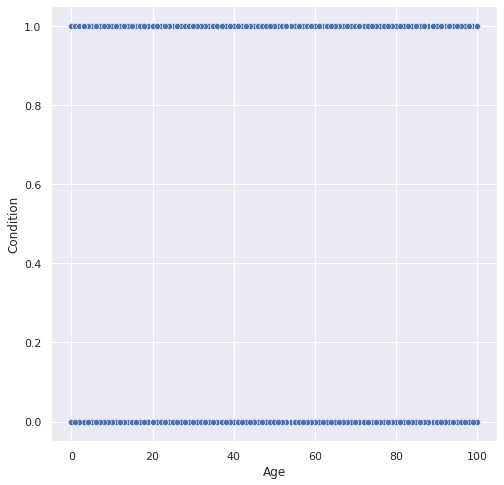

In [6]:
sns.scatterplot(data=chronic, x="Age", y="Condition")
plt.savefig("chronic_plot.png")

In [7]:
prop = chronic.Condition.mean()
( chronic.groupby("Condition")
 .agg(Number = ("Condition","size"))
 .assign(Proportion = [ 1-prop, prop ]) )

,Number,Proportion
Condition,,
0,13303,0.423218
1,18130,0.576782


In [8]:
cohorts = (chronic.groupby("Age", as_index=False)
           .agg(Number = ("Condition","size"), 
                Rate = ("Condition","mean")))
cohorts

,Age,Number,Rate
0,0,796,0.026382
1,1,505,0.063366
2,2,320,0.090625
3,3,258,0.143411
4,4,299,0.100334
...,...,...,...
96,96,13,0.923077
97,97,11,0.909091
98,98,6,0.833333
99,99,2,0.500000


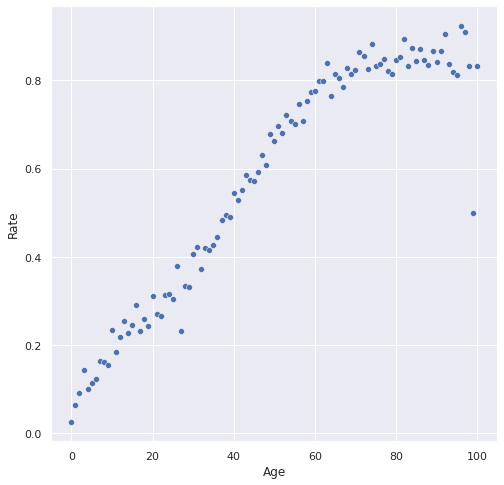

In [9]:
sns.scatterplot(data=cohorts, x="Age", y="Rate")
plt.savefig("chronic_age_cohorts.png")

In [10]:
chronic["Decade"] = 10*round(chronic.Age / 10)
decades = (chronic.groupby("Decade", as_index=False)
           .agg(Total=("Condition","size"), 
                Afflicted=("Condition","sum"),
                Rate=("Condition","mean")))
decades

,Decade,Total,Afflicted,Rate
0,0.0,2440,179,0.073361
1,10.0,1946,368,0.189106
2,20.0,2622,729,0.278032
3,30.0,2673,990,0.370370
4,40.0,3962,2070,0.522463
5,50.0,4426,2953,0.667194
6,60.0,5356,4127,0.770538
7,70.0,3748,3111,0.830043
8,80.0,3357,2831,0.843312
9,90.0,849,726,0.855124


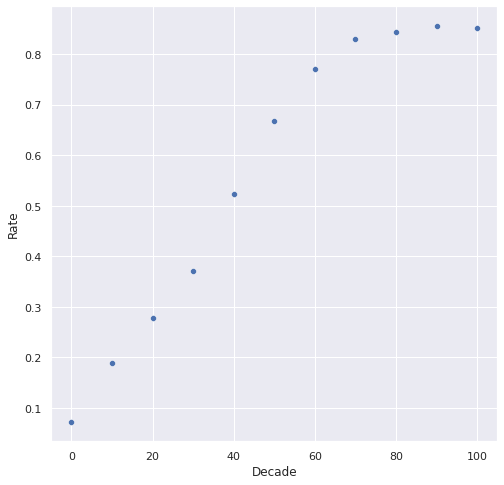

In [11]:
sns.scatterplot(data=decades, x="Decade", y="Rate")
plt.savefig("chronic_cohorts.png")

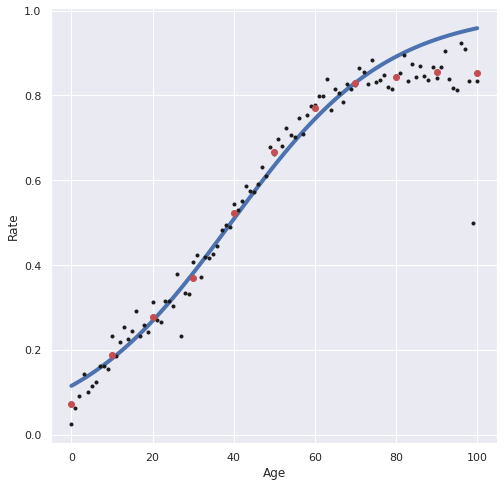

In [12]:
(sns.regplot(data=chronic,
             x="Age", y="Condition",
             logistic=True, scatter=False,
             ci=None, line_kws={"lw":"4"}))
plt.xlim(-5,105)
plt.ylabel("Rate")
plt.plot( cohorts["Age"], cohorts["Rate"],'.k')
plt.plot( decades["Decade"], decades["Rate"],'or',ms=6)
plt.savefig("ages_decades.png")

In [13]:
chronic_model = smf.logit("Condition ~ Age", data=chronic)
chronic_fit = chronic_model.fit()
chronic_fit.params

Optimization terminated successfully.
         Current function value: 0.538249
         Iterations 6


Intercept   -2.039383
Age          0.051815
dtype: float64

In [14]:
print( chronic_fit.summary() )

                           Logit Regression Results                           
Dep. Variable:              Condition   No. Observations:                31433
Model:                          Logit   Df Residuals:                    31431
Method:                           MLE   Df Model:                            1
Date:                Sun, 24 Oct 2021   Pseudo R-squ.:                  0.2100
Time:                        19:29:05   Log-Likelihood:                -16919.
converged:                       True   LL-Null:                       -21416.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -2.0394      0.032    -64.348      0.000      -2.101      -1.977
Age            0.0518      0.001     80.787      0.000       0.051       0.053


In [15]:
chronic["Probability"] = chronic_fit.predict( chronic.Age )
chronic

,Age,Condition,Decade,Probability
0,36,0,40.0,0.456601
1,55,1,60.0,0.692206
2,72,1,70.0,0.844397
3,46,0,50.0,0.585190
4,66,1,70.0,0.799059
...,...,...,...,...
31428,49,1,50.0,0.622357
31429,56,1,60.0,0.703135
31430,6,0,10.0,0.150781
31431,1,0,0.0,0.120514


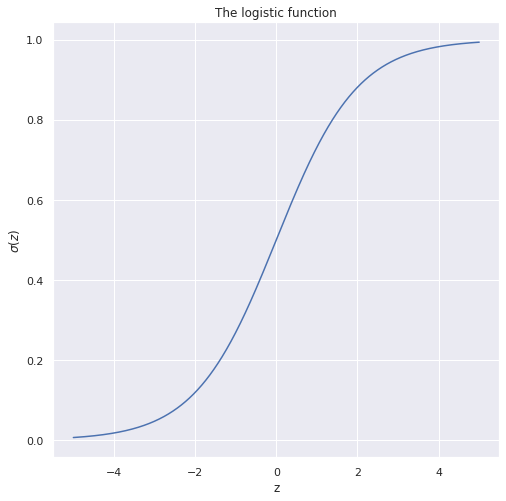

In [16]:
z = np.linspace(-5,5,1000)
sigma = 1 / ( 1 + np.exp(-z))
plt.plot(z, sigma)
plt.xlabel("z")
plt.ylabel(r"$\sigma(z)$")
plt.title("The logistic function")
plt.savefig("logit.png")

In [17]:
chronic["Class"] = (chronic.Probability > 0.50).astype(int)
chronic

,Age,Condition,Decade,Probability,Class
0,36,0,40.0,0.456601,0
1,55,1,60.0,0.692206,1
2,72,1,70.0,0.844397,1
3,46,0,50.0,0.585190,1
4,66,1,70.0,0.799059,1
...,...,...,...,...,...
31428,49,1,50.0,0.622357,1
31429,56,1,60.0,0.703135,1
31430,6,0,10.0,0.150781,0
31431,1,0,0.0,0.120514,0


In [18]:
pd.crosstab(chronic.Condition, chronic.Class)

Class,0,1
Condition,,
0,8294,5009
1,3043,15087


In [19]:
pd.crosstab(chronic.Condition, chronic.Class, normalize='index')

Class,0,1
Condition,,
0,0.623468,0.376532
1,0.167843,0.832157


In [20]:
np.mean( chronic.Condition == chronic.Class )

0.7438360958228614

In [21]:
np.mean( chronic.Condition != chronic.Class )

0.2561639041771387

In [22]:
chronic["Class"] = (chronic.Probability > 0.80).astype(int)
chronic

,Age,Condition,Decade,Probability,Class
0,36,0,40.0,0.456601,0
1,55,1,60.0,0.692206,0
2,72,1,70.0,0.844397,1
3,46,0,50.0,0.585190,0
4,66,1,70.0,0.799059,0
...,...,...,...,...,...
31428,49,1,50.0,0.622357,0
31429,56,1,60.0,0.703135,0
31430,6,0,10.0,0.150781,0
31431,1,0,0.0,0.120514,0


In [23]:
pd.crosstab(chronic.Condition, chronic.Class)

Class,0,1
Condition,,
0,12102,1201
1,11803,6327


In [24]:
pd.crosstab(chronic.Condition, chronic.Class, normalize='index')

Class,0,1
Condition,,
0,0.90972,0.09028
1,0.65102,0.34898


In [25]:
np.mean( chronic.Condition == chronic.Class )

0.5862946584799414

In [26]:
np.mean( chronic.Condition != chronic.Class )

0.41370534152005856

In [27]:
chronic["Class"] = (chronic.Probability > 0.20).astype(int)
chronic

,Age,Condition,Decade,Probability,Class
0,36,0,40.0,0.456601,1
1,55,1,60.0,0.692206,1
2,72,1,70.0,0.844397,1
3,46,0,50.0,0.585190,1
4,66,1,70.0,0.799059,1
...,...,...,...,...,...
31428,49,1,50.0,0.622357,1
31429,56,1,60.0,0.703135,1
31430,6,0,10.0,0.150781,0
31431,1,0,0.0,0.120514,0


In [28]:
pd.crosstab(chronic.Condition, chronic.Class)

Class,0,1
Condition,,
0,3523,9780
1,447,17683


In [29]:
pd.crosstab(chronic.Condition, chronic.Class, normalize='index')

Class,0,1
Condition,,
0,0.264827,0.735173
1,0.024655,0.975345


In [30]:
np.mean( chronic.Condition == chronic.Class )

0.6746413005440143

In [31]:
np.mean( chronic.Condition != chronic.Class )

0.3253586994559857

In [32]:
fpr, tpr, thresholds = metrics.roc_curve(chronic.Condition, chronic.Probability)
chronic_auc = metrics.auc(fpr, tpr)
chronic_auc

0.7938824622209679

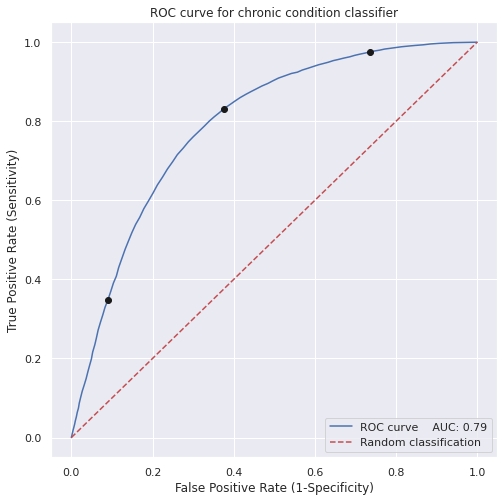

In [33]:
plt.figure()
plt.plot(fpr, tpr, label='ROC curve    AUC: %0.2f' % chronic_auc)
plt.plot([0,1], [0,1], 'r--', label='Random classification')
plt.plot([0.735,0.377,0.09], [0.975,0.832,0.349], 'ok')
# plt.xlim([0, 1]) 
# plt.ylim([0, 1.05])
plt.xlabel('False Positive Rate (1-Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.title('ROC curve for chronic condition classifier')
plt.legend(loc="lower right")
plt.savefig("chronic_roc.png")

In [34]:
cohorts = (chronic.groupby("Age", as_index=False)
           .agg(Number = ("Condition","size"), 
                Successes = ("Condition","sum"),
                Percentage = ("Condition","mean")))
cohorts.insert(3,"Failures", cohorts["Number"] - cohorts["Successes"])
cohorts

,Age,Number,Successes,Failures,Percentage
0,0,796,21,775,0.026382
1,1,505,32,473,0.063366
2,2,320,29,291,0.090625
3,3,258,37,221,0.143411
4,4,299,30,269,0.100334
...,...,...,...,...,...
96,96,13,12,1,0.923077
97,97,11,10,1,0.909091
98,98,6,5,1,0.833333
99,99,2,1,1,0.500000


In [35]:
cohorts.insert(0,"Bias",1)
cohorts

,Bias,Age,Number,Successes,Failures,Percentage
0,1,0,796,21,775,0.026382
1,1,1,505,32,473,0.063366
2,1,2,320,29,291,0.090625
3,1,3,258,37,221,0.143411
4,1,4,299,30,269,0.100334
...,...,...,...,...,...,...
96,1,96,13,12,1,0.923077
97,1,97,11,10,1,0.909091
98,1,98,6,5,1,0.833333
99,1,99,2,1,1,0.500000


In [36]:
cohorts_null_model = sm.GLM( cohorts[["Successes","Failures"]], cohorts["Bias"], family=sm.families.Binomial())
cohorts_null_fit = cohorts_null_model.fit()
print(cohorts_null_fit.summary())

                     Generalized Linear Model Regression Results                     
Dep. Variable:     ['Successes', 'Failures']   No. Observations:                  101
Model:                                   GLM   Df Residuals:                      100
Model Family:                       Binomial   Df Model:                            0
Link Function:                         logit   Scale:                          1.0000
Method:                                 IRLS   Log-Likelihood:                -4962.2
Date:                       Sun, 24 Oct 2021   Deviance:                       9369.4
Time:                               19:29:08   Pearson chi2:                 8.63e+03
No. Iterations:                            4                                         
Covariance Type:                   nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------

In [37]:
null_odds = np.exp( cohorts_null_fit.params["Bias"] )
pi_null = null_odds / (1 + null_odds)
pi_null
cohorts["Null deviance"] = (2*( cohorts["Successes"]*np.log( cohorts["Percentage"]/pi_null ) + 
                               cohorts["Failures"]*np.log( (1 - cohorts["Percentage"] )/(1 - pi_null) ) ))
cohorts

,Bias,Age,Number,Successes,Failures,Percentage,Null deviance
0,1,0,796,21,775,0.026382,1161.794446
1,1,1,505,32,473,0.063366,610.161711
2,1,2,320,29,291,0.090625,337.812295
3,1,3,258,37,221,0.143411,208.652149
4,1,4,299,30,269,0.100334,300.788097
...,...,...,...,...,...,...,...
96,1,96,13,12,1,0.923077,7.875780
97,1,97,11,10,1,0.909091,6.023549
98,1,98,6,5,1,0.833333,1.815906
99,1,99,2,1,1,0.500000,0.047729


In [38]:
np.sum( cohorts["Null deviance"])

9369.377128605302

In [39]:
cohorts_model = sm.GLM( cohorts[["Successes","Failures"]], cohorts[["Bias","Age"]], family=sm.families.Binomial())
cohorts_fit = cohorts_model.fit()
print(cohorts_fit.summary())

                     Generalized Linear Model Regression Results                     
Dep. Variable:     ['Successes', 'Failures']   No. Observations:                  101
Model:                                   GLM   Df Residuals:                       99
Model Family:                       Binomial   Df Model:                            1
Link Function:                         logit   Scale:                          1.0000
Method:                                 IRLS   Log-Likelihood:                -465.35
Date:                       Sun, 24 Oct 2021   Deviance:                       375.77
Time:                               19:29:08   Pearson chi2:                     383.
No. Iterations:                            5                                         
Covariance Type:                   nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------

In [40]:
cohorts["Probability"] = cohorts_fit.predict()
cohorts["Deviance"] = (2*( cohorts["Successes"]*np.log( cohorts["Percentage"]/cohorts["Probability"] ) + 
                cohorts["Failures"]*np.log( (1 - cohorts["Percentage"] )/(1 - cohorts["Probability"]) ) ))
cohorts

,Bias,Age,Number,Successes,Failures,Percentage,Null deviance,Probability,Deviance
0,1,0,796,21,775,0.026382,1161.794446,0.115130,86.263867
1,1,1,505,32,473,0.063366,610.161711,0.120514,18.413977
2,1,2,320,29,291,0.090625,337.812295,0.126115,4.001841
3,1,3,258,37,221,0.143411,208.652149,0.131937,0.289567
4,1,4,299,30,269,0.100334,300.788097,0.137986,3.881705
...,...,...,...,...,...,...,...,...,...
96,1,96,13,12,1,0.923077,7.875780,0.949544,0.164944
97,1,97,11,10,1,0.909091,6.023549,0.951969,0.354287
98,1,98,6,5,1,0.833333,1.815906,0.954284,1.231814
99,1,99,2,1,1,0.500000,0.047729,0.956492,3.585992


In [41]:
np.sum( cohorts["Deviance"])

375.7650234849706

In [42]:
G2_cohorts = cohorts_null_fit.deviance - cohorts_fit.deviance
G2_cohorts

8993.61210512033

In [43]:
1 - st.chi2.cdf( G2_cohorts, df=1 )

0.0

In [44]:
cohorts_fit.deviance

375.7650234849706

In [45]:
cohorts_fit.df_resid

99

In [46]:
1 - st.chi2.cdf( cohorts_fit.deviance, cohorts_fit.df_resid )

0.0

In [48]:
cohorts_fit.pearson_chi2

383.2638432548808

In [49]:
1 - st.chi2.cdf(cohorts_fit.pearson_chi2,  cohorts_fit.df_resid)

0.0

In [53]:
cohort_residuals = pd.DataFrame( {"Age" : cohorts["Age"],
                                  "Pearson" : cohorts_fit.resid_pearson,
                                  "Deviance" : cohorts_fit.resid_deviance} )
cohort_residuals

,Age,Pearson,Deviance
0,0,-7.844772,-9.287834
1,1,-3.944698,-4.291151
2,2,-1.912377,-2.000460
3,3,0.544562,0.538115
4,4,-1.887735,-1.970204
...,...,...,...
96,96,-0.435976,-0.406134
97,97,-0.665066,-0.595220
98,98,-1.418436,-1.109871
99,99,-3.164625,-1.893672


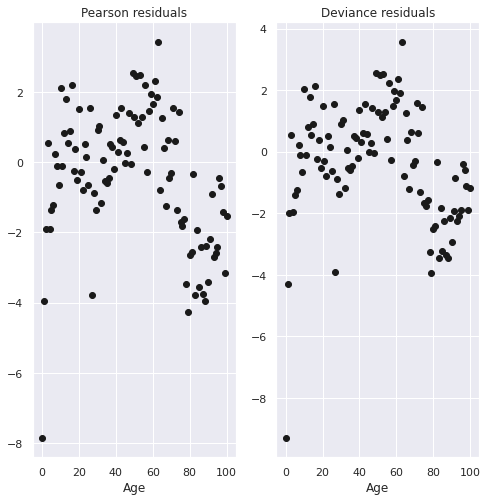

In [61]:
fig, (ax1, ax2) = plt.subplots(1, 2)

ax1.plot( cohort_residuals["Age"], cohort_residuals["Pearson"],'ok')
ax1.set_title("Pearson residuals")
ax1.set_xlabel("Age")
ax2.plot( cohort_residuals["Age"], cohort_residuals["Deviance"],'ok')
ax2.set_title("Deviance residuals")
ax2.set_xlabel("Age")
plt.savefig("cohort_residuals.png")